En este notebook implementamos los modelos

In [195]:
import torch.optim as optim
import torch
from sklearn.metrics import *
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.init as init
import importlib
import kagglehub
import data
import agente
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import islice
importlib.reload(data)
importlib.reload(agente)

<module 'agente' from 'd:\\Universidad\\Aprendizaje-Automatico-y-Big-Data\\Practica5\\agente.py'>

In [90]:
#Aqui habría que poner la linea de codigo para descargar el dataset
#El dataset tiene un par de fotos en los que el formato del nombre de la imagen esta mal; yo las he borrado directamente pero en google colab no se puedem borrar archivos
#por eso no he puesto el codigo de la descarga
#Cuando hagas pruebas tu carga el dataset entero en dataset = data.ImgDataset(utk_ruta,transform=transform) y cuando los tengas cargados quita las foto de dataset que den problemas
#Son aquellas que eran de la forma edad_año_fecha.jpg


In [188]:
#solo sirve en mi ordena ichi esta linea
utk_ruta = "C:\\Users\\Adrian\\.cache\\kagglehub\\datasets\\jangedoo\\utkface-new\\versions\\1\\UTKFace"

# Transformar dataset 
Transformamos las imagenes en una estructura de datos con la que podamos trabajar

In [189]:
#Adaptamos las imagenes a un dataset
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #Esto normalizara las imagenes
dataset = data.ImgDataset(utk_ruta,transform=transform) #Pasamos las imagenes a la estructura de datos

GENERO = ('Hombre','Mujer')
RAZA = ('Blanco','Negrata','Chinito','Indio','Otros')


In [190]:
# Crear los DataLoaders
train_dataloader,test_dataloader = data.entrenamientoTest(dataset=dataset,test_size=0.2,batch_size=4)

print(len(train_dataloader))
print(len(test_dataloader))

4741
1186


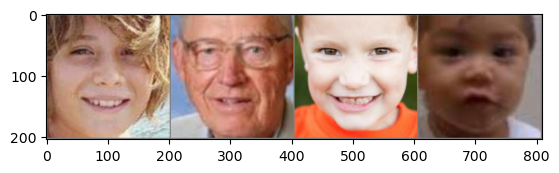

Edad:     9.0  73.0   7.0   4.0
Genero: Hombre Hombre Hombre Hombre
Raza:   Blanco Blanco Blanco Otros


In [191]:
# Display image and label.
imagenes, edades,generos,razas = next(iter(train_dataloader))

# show images
data.mostrarImg(imagenes)
print('Edad:  ',' '.join('%5s' % edades[j].item() for j in range(4)))
print('Genero:',' '.join('%5s' % GENERO[generos[j].item()] for j in range(4)))
print('Raza:  ',' '.join('%5s' % RAZA[razas[j].item()] for j in range(4)))


In [192]:
def graficaEntrenamiento(train_loss,train_accuracy,test_loss,test_accuracy,epochs):
    x1 = np.arange(0,epochs)
    x2 = np.arange(0,epochs+1,5)

    
    fig,axs = plt.subplots(1,2)

    #Loss
    axs[0].plot(x1,train_loss,label = "Train Loss", color = 'b')
    axs[0].plot(x2,test_loss,label = "Test Loss", color = 'r')
    axs[0].set_title('Loss')  # Título del primer gráfico
    axs[0].set_xlabel('Epochs')  # Etiqueta del eje X
    axs[0].set_ylabel('Loss')  # Etiqueta del eje Y
    axs[0].legend()
    axs[0].grid(True)

    #Train
    axs[1].plot(x1,train_accuracy,label = "Train Acurracy", color = 'b')
    axs[1].plot(x2,test_accuracy,label = "Test Acurracy", color = 'r')
    axs[1].set_title('Accuracy')  # Título del primer gráfico
    axs[1].set_xlabel('Epochs')  # Etiqueta del eje X
    axs[1].set_ylabel('Acurracy')  # Etiqueta del eje Y
    axs[1].legend()
    axs[1].grid(True)
    
    plt.grid(True)
    plt.tight_layout()  # Ajusta el espaciado entre los subgráficos
    plt.show()


# Modelo 1: Denzel Washington

Entrenaremos 3 modelos distintos, uno por cada objetivo que queremos predecir. 

Ambos modelos tendrán la misma estructura excepto en la ultima capa. 

Además el entrenamiento será distinto para cada uno de ellos pues utilizaremos distintos criterios y optimizadores segun el objetivo

In [133]:
class DenzelWashington(nn.Module):
    def __init__(self,output_layers):
        super().__init__()

        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.pool2 = nn.MaxPool2d(4, 4)
       
        self.fc1 = nn.Linear(12 * 11 * 11, 500)
        self.fcout = nn.Linear(500, output_layers)

        self.apply(self._init_weights)  # Aplicar la inicialización de pesos

    def _init_weights(self, m):
        """Inicializa los pesos de la red"""
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                init.constant_(m.bias, 0)

    def forward(self, x):

        x = self.pool1(x) #3 fotos 100x100
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.fcout(x)
        return x




In [134]:
#Esto sirve para ver en que dispositivo se entrena.
#GPU(cuda) es mas rapido que CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Entrenando en: {device}")

Entrenando en: cuda


Creamos un agente con los 3 modelos siguientes:

In [152]:
#Modelo edad
DWEdad = DenzelWashington(output_layers=1).to(device)
mseLoss = nn.MSELoss()

#Modelo Genero
DWGenero = DenzelWashington(output_layers=2).to(device)
entropyLossGen = nn.CrossEntropyLoss()

#Modelo raza
DWRaza = DenzelWashington(output_layers=5).to(device)
entropyLossRaza = nn.CrossEntropyLoss()

agenteDW = agente.Agente(modeloEdad=DWEdad,
                         modeloGenero=DWGenero,
                         modeloRaza=DWRaza,
                         criterioEdad=mseLoss,
                         criterioGenero=entropyLossGen,
                         criterioRaza=entropyLossRaza,
                         device=device,
                         lr = 0.0001)


Entrenamos los 3 modelos 150 epochs

In [156]:
train_loss_Genero,train_accuracy_Genero,test_loss_Genero,test_accuracy_Genero = agenteDW.entrenarModelo(train_dataloader,test_dataloader,"Genero",num_epochs=15)

[1, Genero] loss: 0.106
[1, Genero] accuracy: 0.802
[2, Genero] loss: 0.079
[2, Genero] accuracy: 0.860
[3, Genero] loss: 0.071
[3, Genero] accuracy: 0.880
[4, Genero] loss: 0.065
[4, Genero] accuracy: 0.891
[5, Genero] loss: 0.060
[5, Genero] accuracy: 0.899
[6, Genero] loss: 0.055
[6, Genero] accuracy: 0.910
[7, Genero] loss: 0.050
[7, Genero] accuracy: 0.920
[8, Genero] loss: 0.044
[8, Genero] accuracy: 0.931
[9, Genero] loss: 0.040
[9, Genero] accuracy: 0.939
[10, Genero] loss: 0.035
[10, Genero] accuracy: 0.948
[11, Genero] loss: 0.030
[11, Genero] accuracy: 0.957
[12, Genero] loss: 0.025
[12, Genero] accuracy: 0.964
[13, Genero] loss: 0.021
[13, Genero] accuracy: 0.970
[14, Genero] loss: 0.018
[14, Genero] accuracy: 0.975
[15, Genero] loss: 0.015
[15, Genero] accuracy: 0.979
Finished Training Genero


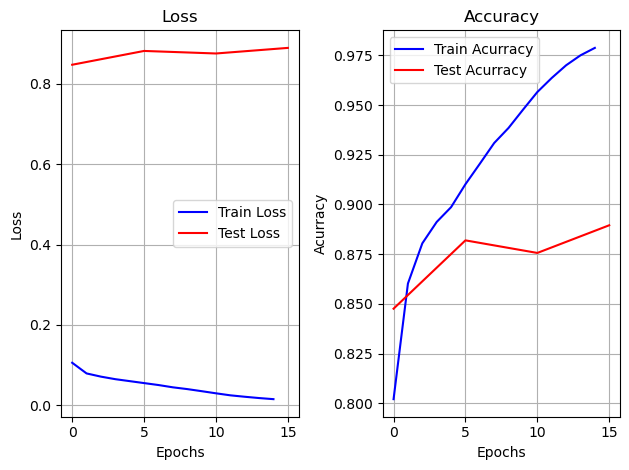

In [193]:
graficaEntrenamiento(train_loss_Genero,train_accuracy_Genero,test_accuracy_Genero,test_accuracy_Genero,15)

In [ ]:
#Entrenamos el agente
agenteDW.entrenarModelo(train_data=train_dataloader,tarea="Genero",num_epochs=150)
agenteDW.entrenarModelo(train_data=train_dataloader,tarea="Edad",num_epochs=150)
torch.save(agenteDW.modeloEdad.state_dict(), './DWEdad2.pth')
agenteDW.entrenarModelo(train_data=train_dataloader,tarea="Raza",num_epochs=150)
torch.save(agenteDW.modeloRaza.state_dict(), './DWRaza2.pth')

In [12]:
agenteDW.modeloEdad.load_state_dict(torch.load('DWEdad1.pth'))
agenteDW.modeloGenero.load_state_dict(torch.load('DWGenero1.pth'))
agenteDW.modeloRaza.load_state_dict(torch.load('DWRaza.pth'))

<All keys matched successfully>

# Resultados


In [172]:
edadesTotal,edadesPredTotal,generosTotal,generosPredTotal,razasTotal,razasPredTotal = agenteDW.resultados(test_dataloader)

- Tasa de aciertos


In [174]:
print(f'Tasa aciertos de la red en EDAD: {accuracy_score(edadesTotal,edadesPredTotal)*100} %')
print(f'Tasa aciertos de la red en GENERO: {accuracy_score(generosTotal,generosPredTotal)*100} %')
print(f'Tasa aciertos de la red en RAZA: {accuracy_score(razasTotal,razasPredTotal)*100} %')

Tasa aciertos de la red en EDAD: 0.0 %
Tasa aciertos de la red en GENERO: 88.99198650358498 %
Tasa aciertos de la red en RAZA: 29.56558414171236 %


In [180]:
report = classification_report(generosTotal, generosPredTotal,target_names=GENERO)
print(report)

              precision    recall  f1-score   support

      Hombre       0.90      0.89      0.89      2483
       Mujer       0.88      0.89      0.89      2259

    accuracy                           0.89      4742
   macro avg       0.89      0.89      0.89      4742
weighted avg       0.89      0.89      0.89      4742



El modelo no es capaz de determinar la edad exacta ¿ pero cuanto se equivoca? Error absoluto medio 

In [20]:
print(f'Error absoluto medio(Edad): {mean_absolute_error(edadesTotal, edadesPredTotal)}')

Error absoluto medio(Edad): 33.368409953606076


- Matriz confusion

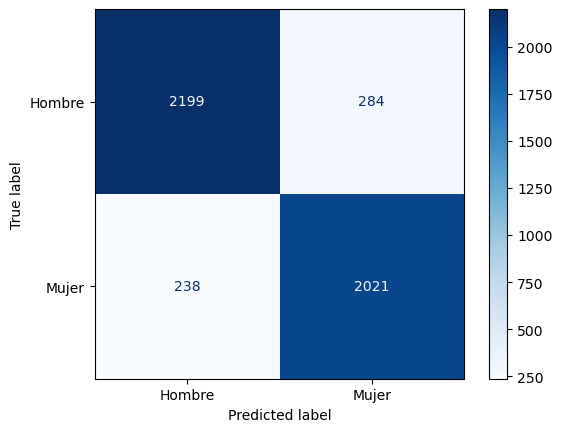

In [200]:
matrizGenero = confusion_matrix(generosTotal, generosPredTotal)
disp = ConfusionMatrixDisplay(confusion_matrix=matrizGenero,display_labels=GENERO)
disp.plot(cmap = plt.cm.Blues)
plt.show()

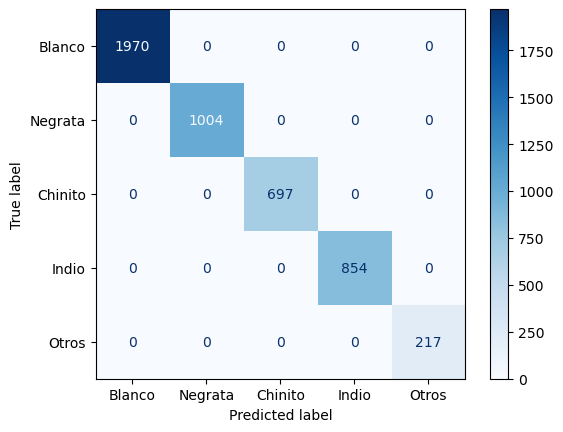

In [101]:
matrizRaza = confusion_matrix(razasPredTotal, razasPredTotal)
disp = ConfusionMatrixDisplay(confusion_matrix=matrizRaza,display_labels=RAZA)
disp.plot(cmap = plt.cm.Blues)
plt.show()

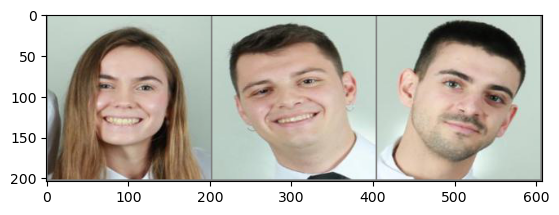

Valor real
Genero: Mujer Hombre Hombre
Predicciones
Genero: Mujer Mujer Mujer
Edad: 0.0006109115201979876 0.001647871220484376 0.004043773747980595


In [185]:
tempusFugit = data.ImgDataset("./fotos",transform=transform)
imagenes = [imagen for imagen, _, _,_ in tempusFugit ]
generos = [genero for _,_, genero,_ in tempusFugit]

imagenes = torch.stack(imagenes,dim = 0)
generos = torch.stack(generos,dim=0)

imagenes = imagenes.to(device)

data.mostrarImg(imagenes)
predicciones = agenteDW.modeloGenero(imagenes)
edades = agenteDW.modeloEdad(imagenes)    
_, generosPred = torch.max(predicciones, 1)

print("Valor real")
print('Genero:',' '.join('%5s' % GENERO[generos[j].item()] for j in range(3)))
print("Predicciones")
print('Genero:',' '.join('%5s' % GENERO[generosPred[j].item()] for j in range(3)))
print('Edad:',' '.join('%5s' % edades[j].item() for j in range(3)))


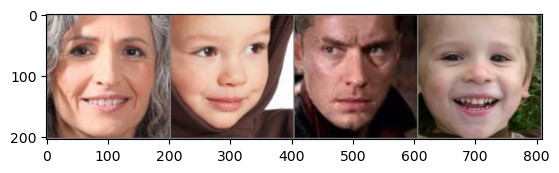

Valor real
Genero: Mujer Hombre Hombre Hombre
Predicciones
Genero: Mujer Hombre Mujer Mujer
Edad: 0.005117699503898621 0.004574227146804333 0.0037110638804733753 0.0029890784062445164


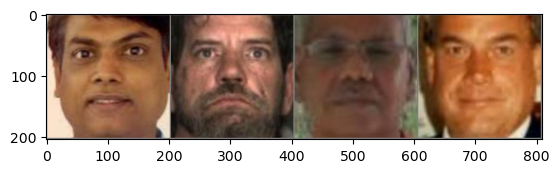

Valor real
Genero: Hombre Hombre Hombre Hombre
Predicciones
Genero: Hombre Hombre Hombre Hombre
Edad: 0.003710441291332245 0.002699110424146056 0.0015556286089122295 0.003091050311923027


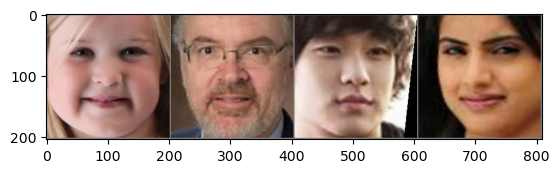

Valor real
Genero: Mujer Hombre Hombre Mujer
Predicciones
Genero: Mujer Hombre Hombre Mujer
Edad: 0.0021746749989688396 0.0024695806205272675 0.0047982847318053246 0.002410455606877804


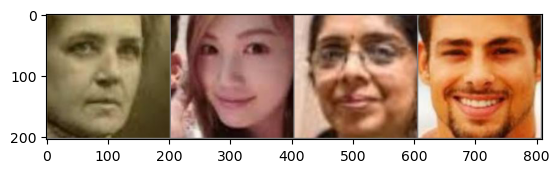

Valor real
Genero: Mujer Mujer Mujer Hombre
Predicciones
Genero: Mujer Mujer Mujer Hombre
Edad: 0.00177741888910532 0.002595681231468916 0.0036550089716911316 0.004305848851799965


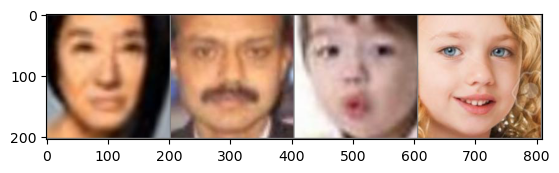

Valor real
Genero: Mujer Hombre Hombre Mujer
Predicciones
Genero: Mujer Hombre Mujer Mujer
Edad: 0.002751113846898079 0.0021122503094375134 0.00476647075265646 0.003689895151183009


In [196]:
for batch in islice(test_dataloader,5):
    imagenes, edades,generos,razas = batch
    imagenes = imagenes.to(device)

    data.mostrarImg(imagenes)
    predicciones = agenteDW.modeloGenero(imagenes)
    edades = agenteDW.modeloEdad(imagenes)    
    _, generosPred = torch.max(predicciones, 1)

    print("Valor real")
    print('Genero:',' '.join('%5s' % GENERO[generos[j].item()] for j in range(4)))
    print("Predicciones")
    print('Genero:',' '.join('%5s' % GENERO[generosPred[j].item()] for j in range(4)))
    print('Edad:',' '.join('%5s' % edades[j].item() for j in range(4)))

# Modelo 2: Lola Lolita

In [33]:
class LolaLolita(nn.Module):
    def __init__(self,output_layers):
        super().__init__()

        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(6, 12, 4)
        self.conv3 = nn.Conv2d(12,24,6)
        self.conv4 =  nn.Conv2d(24,48,16)
        self.pool2 = nn.MaxPool2d(3, 3)
       
        self.fc1 = nn.Linear(48 * 100, 1200)
        self.fc2 = nn.Linear(1200, 850)
        self.fcout = nn.Linear(850, output_layers)

        self.apply(self._init_weights)  # Aplicar la inicialización de pesos

    def _init_weights(self, m):
        """Inicializa los pesos de la red"""
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                init.constant_(m.bias, 0)

    def forward(self, x):

        x = self.pool1(x) 
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(F.relu(self.conv3(x)))
        x = self.pool2(F.relu(self.conv4(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fcout(x)
        return x

In [34]:
#Esto sirve para ver en que dispositivo se entrena.
#GPU(cuda) es mas rapido que CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Entrenando en: {device}")

Entrenando en: cuda


In [39]:
a  = 0.0001
#Modelo edad
LLEdad = LolaLolita(output_layers=1).to(device)
mseLoss = nn.MSELoss()

#Modelo Genero
LLGenero = LolaLolita(output_layers=2).to(device)
entropyLossGen = nn.CrossEntropyLoss()

#Modelo raza
LLRaza = LolaLolita(output_layers=5).to(device)
entropyLossRaza = nn.CrossEntropyLoss()

agenteLL= agente.Agente(modeloEdad=LLEdad,
                         modeloGenero=LLGenero,
                         modeloRaza=LLRaza,
                         criterioEdad=mseLoss,
                         criterioGenero=entropyLossGen,
                         criterioRaza=entropyLossRaza,
                         device=device,
                         lr = 0.00001)

In [15]:
agenteLL.modeloGenero.load_state_dict(torch.load('./LLGenero.pth'))

<All keys matched successfully>

In [40]:
for i in range(0,20):
    agenteLL.entrenarModelo(train_data=train_dataloader,tarea="Genero",num_epochs=5)
    torch.save(agenteLL.modeloGenero.state_dict(), './LLGenero.pth')

[1, Genero] loss: 0.129
[1, Genero] accuracy: 0.745


KeyboardInterrupt: 

In [37]:
#Entrenar genero: 100 epochs
for i in range(0,20):
    agenteLL.entrenarModelo2(train_data=train_dataloader,tarea="Genero",num_epochs=5)
    torch.save(agenteLL.modeloGenero.state_dict(), './LLGenero.pth')

[1, edad] loss: 2.099


KeyboardInterrupt: 

In [ ]:
#Entrenar genero: 100 epochs
for i in range(0,20):
    agenteLL.entrenarModelo(train_data=train_dataloader,tarea="Genero",num_epochs=5)
    torch.save(agenteLL.modeloGenero.state_dict(), './LLGenero.pth')


[1, Genero] loss: 1.464
[2, Genero] loss: 1.293
[3, Genero] loss: 1.198
[4, Genero] loss: 1.117
[5, Genero] loss: 1.056
Finished Training Genero
[1, Genero] loss: 0.986
[2, Genero] loss: 0.924
[3, Genero] loss: 0.866
[4, Genero] loss: 0.802
[5, Genero] loss: 0.741
Finished Training Genero
[1, Genero] loss: 0.675
[2, Genero] loss: 0.612
[3, Genero] loss: 0.552
[4, Genero] loss: 0.484
[5, Genero] loss: 0.426
Finished Training Genero
[1, Genero] loss: 0.374
[2, Genero] loss: 0.327
[3, Genero] loss: 0.290
[4, Genero] loss: 0.257
[5, Genero] loss: 0.231
Finished Training Genero
[1, Genero] loss: 0.208
[2, Genero] loss: 0.190
[3, Genero] loss: 0.175
[4, Genero] loss: 0.158
[5, Genero] loss: 0.150
Finished Training Genero
[1, Genero] loss: 0.149
[2, Genero] loss: 0.119
[3, Genero] loss: 0.125
[4, Genero] loss: 0.114
[5, Genero] loss: 0.104
Finished Training Genero
[1, Genero] loss: 0.104
[2, Genero] loss: 0.093
[3, Genero] loss: 0.091
[4, Genero] loss: 0.088
[5, Genero] loss: 0.079
Finished T

KeyboardInterrupt: 